In [1]:
#라이브러리 import 및 설정
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [2]:
rcParams['figure.figsize'] = (16, 8)       #그림 사이즈 지정
plt.style.use('fivethirtyeight')           #그림 기본 스타일
pd.set_option('max_columns', 100)          #칼럼 100개 허용
pd.set_option("display.precision", 4)      #소수점 4자리허용
warnings.simplefilter('ignore')            #경고분 무시

In [16]:
#학습데이터 로드
data_dir = Path('C:\\Users\\USER\\Desktop\\경진대회_dataset\\DataInput')
sub_dir = Path('C:\\Users\\USER\\Desktop\\경진대회_dataset\\sub')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'
sub_file = sub_dir / f'{model_name}.csv'

In [17]:
df_tst= pd.read_csv(tst_file, header=None)
print(df_tst.shape)
df_tst.head()                                       #(4280, 32)

(1833, 31)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,185,130,100,119,142,110,89,102,114,87,84,106,87,84,102,87,84,106,111,80,95,100,81,84,103,108,88,88,112,113,88
1,178,139,100,104,142,114,63,97,114,94,64,111,91,60,102,91,57,102,115,60,95,108,88,60,95,113,92,53,95,108,88
2,182,125,97,112,137,105,78,97,105,83,84,111,87,84,102,87,84,98,106,80,99,108,85,84,103,108,85,80,99,104,81
3,174,113,83,97,115,89,63,63,82,69,72,82,65,64,73,65,60,66,78,71,75,83,59,64,68,75,63,64,68,83,67
4,167,144,107,97,146,124,67,111,114,101,68,120,98,68,111,102,72,111,120,68,112,122,99,68,107,128,96,71,112,128,99


In [18]:
df = pd.read_csv(trn_file, header=None)
print(df.shape)
df.head()                                       #(4280, 32)

(4280, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,HI,188,128,95,114,143,108,88,103,113,85,88,113,87,88,103,87,84,99,104,82,96,100,78,70,79,84,66,70,75,76,63
1,PH,174,112,88,104,119,92,74,79,88,74,67,90,68,71,73,68,71,77,90,67,71,82,65,70,75,89,73,67,71,89,73
2,GR,175,138,106,105,135,109,75,95,113,96,74,112,96,70,87,100,66,83,117,67,88,110,98,67,88,119,98,75,91,110,94
3,PH,176,111,80,106,131,96,76,99,104,85,75,89,75,79,91,75,84,103,109,82,91,96,78,78,91,96,78,82,104,112,85
4,EL,182,144,111,100,151,119,67,106,114,90,76,115,94,68,106,91,68,102,115,71,95,108,88,71,103,113,92,68,107,118,92


In [7]:
y = df.iloc[:,0].values[:4280]                  #종속
df.drop(df.columns[[0]], axis=1, inplace=True)  #독립을 위한 종속 제거
trn = df.iloc[:4280]                            #독립_학습 데이터
print(y.shape, trn.shape, df_tst.shape)         #(4280,) (4280, 31) (1833, 31)

(4280,) (4280, 31) (1833, 31)


In [8]:
seed = 150 
#적정값이 있었음 너무 낮거나 높음 떨어짐
#107: 91.2383%   150: 91.7056%  100: 90.7710%

#학습/검증 데이터 구분_[Hold-out Validation]
#>학습 후 모델의 예측/분류 정확도 계산을 위한 검증데이터 분리
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(3424, 31) (856, 31) (3424,) (856,)


In [9]:
#LightGBM 모델 학습
clf = lgb.LGBMClassifier(objective='multiclass',
                         boosting_type='dart', 
                         n_estimators=100,
                         num_iterations= 500,
                         num_leaves=31,                    
                         #2의 자승으로 줄 것
                         learning_rate=0.034651056924106347,
                         #작을 수록 스케일이 줄어든다. 원하는 예측값까지 
                         #수렴하기 위해 큰 변동(Oscillation)없이 안정적으로 도달 가능 
                         #대신 필요한 개별 결정트리 증가로 학습시간이 급증할 수 있다.
                         subsample_freq=1,
                         #각 트리 샘플링 빈도
                         colsample_bytree= 0.6000000000000001,
                         #피처 샘플링 빈도(80% 사용)
                         sample=0.8,
                         random_state=seed,
                         n_jobs=-1)

clf.fit(X_trn, y_trn,                  #학습 데이터로 훈련(learning)
        eval_set=[(X_val, y_val)],     #+ eval_set: 검증 데이터 패스, 
        eval_metric='multiclass',      #+ eval_metric: 매번 실행하는 횟수마다 로그손실 확인 가능
        early_stopping_rounds=15)      #+ eval_metric: 손실함수 향상의 계산 한계를 지정
                                    
p_val = clf.predict(X_val)             #학습데이터로 훈련시킨 모델에 검증데이터로 예측값 추출
p_tst = clf.predict(df_tst)             #학습데이터로 훈련시킨 모델에 시험데이터로 예측값 추출

[LightGBM] [Warning] Unknown parameter: sample
[1]	valid_0's multi_logloss: 1.60122
[2]	valid_0's multi_logloss: 1.49721
[3]	valid_0's multi_logloss: 1.40688
[4]	valid_0's multi_logloss: 1.3271
[5]	valid_0's multi_logloss: 1.25554
[6]	valid_0's multi_logloss: 1.19063
[7]	valid_0's multi_logloss: 1.13233
[8]	valid_0's multi_logloss: 1.07836
[9]	valid_0's multi_logloss: 1.07908
[10]	valid_0's multi_logloss: 1.10063
[11]	valid_0's multi_logloss: 1.13511
[12]	valid_0's multi_logloss: 1.08143
[13]	valid_0's multi_logloss: 1.06326
[14]	valid_0's multi_logloss: 1.08029
[15]	valid_0's multi_logloss: 1.03043
[16]	valid_0's multi_logloss: 0.984405
[17]	valid_0's multi_logloss: 1.01406
[18]	valid_0's multi_logloss: 0.969298
[19]	valid_0's multi_logloss: 0.927927
[20]	valid_0's multi_logloss: 0.942765
[21]	valid_0's multi_logloss: 0.903654
[22]	valid_0's multi_logloss: 0.91032
[23]	valid_0's multi_logloss: 0.925871
[24]	valid_0's multi_logloss: 0.888588
[25]	valid_0's multi_logloss: 0.903872
[26]	

[217]	valid_0's multi_logloss: 0.2986
[218]	valid_0's multi_logloss: 0.295475
[219]	valid_0's multi_logloss: 0.292334
[220]	valid_0's multi_logloss: 0.290004
[221]	valid_0's multi_logloss: 0.291658
[222]	valid_0's multi_logloss: 0.288999
[223]	valid_0's multi_logloss: 0.286291
[224]	valid_0's multi_logloss: 0.287597
[225]	valid_0's multi_logloss: 0.288958
[226]	valid_0's multi_logloss: 0.286546
[227]	valid_0's multi_logloss: 0.287917
[228]	valid_0's multi_logloss: 0.289139
[229]	valid_0's multi_logloss: 0.28646
[230]	valid_0's multi_logloss: 0.287718
[231]	valid_0's multi_logloss: 0.289231
[232]	valid_0's multi_logloss: 0.286296
[233]	valid_0's multi_logloss: 0.283699
[234]	valid_0's multi_logloss: 0.285093
[235]	valid_0's multi_logloss: 0.282732
[236]	valid_0's multi_logloss: 0.284048
[237]	valid_0's multi_logloss: 0.281912
[238]	valid_0's multi_logloss: 0.279922
[239]	valid_0's multi_logloss: 0.281142
[240]	valid_0's multi_logloss: 0.282456
[241]	valid_0's multi_logloss: 0.283781
[24

[425]	valid_0's multi_logloss: 0.238052
[426]	valid_0's multi_logloss: 0.237595
[427]	valid_0's multi_logloss: 0.237539
[428]	valid_0's multi_logloss: 0.237423
[429]	valid_0's multi_logloss: 0.237432
[430]	valid_0's multi_logloss: 0.237491
[431]	valid_0's multi_logloss: 0.237468
[432]	valid_0's multi_logloss: 0.237468
[433]	valid_0's multi_logloss: 0.237463
[434]	valid_0's multi_logloss: 0.237479
[435]	valid_0's multi_logloss: 0.237473
[436]	valid_0's multi_logloss: 0.237482
[437]	valid_0's multi_logloss: 0.237254
[438]	valid_0's multi_logloss: 0.237278
[439]	valid_0's multi_logloss: 0.23714
[440]	valid_0's multi_logloss: 0.236925
[441]	valid_0's multi_logloss: 0.236881
[442]	valid_0's multi_logloss: 0.236863
[443]	valid_0's multi_logloss: 0.236951
[444]	valid_0's multi_logloss: 0.236872
[445]	valid_0's multi_logloss: 0.236693
[446]	valid_0's multi_logloss: 0.236687
[447]	valid_0's multi_logloss: 0.2364
[448]	valid_0's multi_logloss: 0.236249
[449]	valid_0's multi_logloss: 0.236237
[45

In [12]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

91.7056%


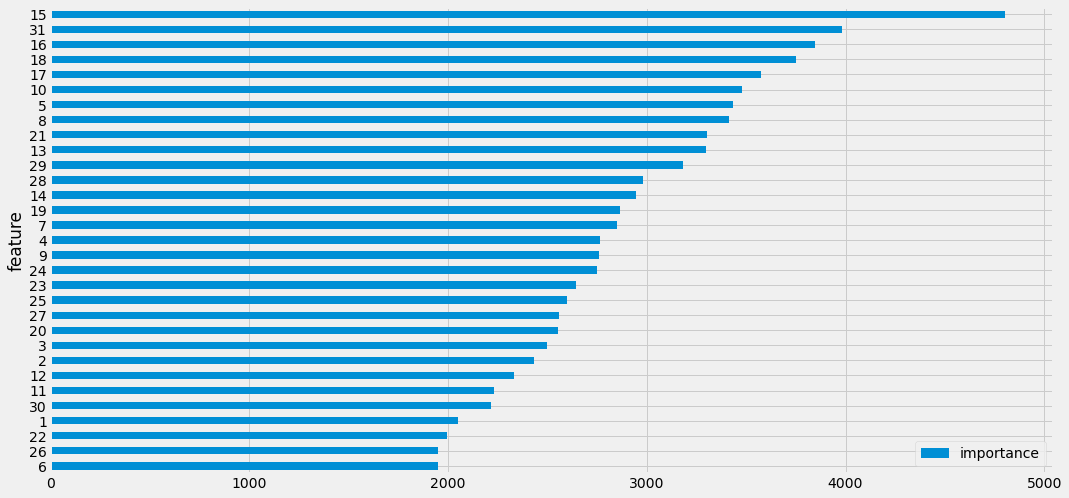

In [10]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [11]:
#제출 파일 생성
sub = pd.read_csv(sample_file)
sub['class'] = p_tst

In [ ]:
sub.to_csv(sub_file)

In [22]:
'''
최저 파라미터
print(params)
{'objective': 'multiclass', 'subsample_freq': 1,
 'random_state': 107, 'n_jobs': -1,
 'colsample_bytree': 0.6000000000000001, 
 'learning_rate': 0.03878586662687423, 'n_estimators': 200, 
 'num_iterations': 100, 'num_leaves': 254, 
 'subsample': 0.7000000000000001}
#90.3037%(최적) &90.5374%(좀 삭제시)& 90.5374%(주석)_0.910480349344978 
{'objective': 'multiclass', 'subsample_freq': 1, 
 'random_state': 107, 'n_jobs': -1, 'boosting_type': 'dart', 
 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.034651056924106347,
 'n_estimators': 100, 'num_iterations': 500, 'num_leaves': 31, 
 'subsample': 0.8}
91.2383%!!!!(주석 X)
{'objective': 'multiclass', 'subsample_freq': 1,
 'random_state': 107, 'n_jobs': -1, 'boosting_type': 'gbdt',
 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.035249105850575155, 
 'n_estimators': 600, 'num_iterations': 500, 'num_leaves': 127,
 'subsample': 0.6000000000000001}
90.5374%!(주석 X)
'''

"\n최저 파라미터\nprint(params)\n{'objective': 'multiclass', 'subsample_freq': 1,\n 'random_state': 107, 'n_jobs': -1,\n 'colsample_bytree': 0.6000000000000001, \n 'learning_rate': 0.03878586662687423, 'n_estimators': 200, \n 'num_iterations': 100, 'num_leaves': 254, \n 'subsample': 0.7000000000000001}\n#90.3037%(최적) &90.5374%(좀 삭제시)& 90.5374%(주석)_0.910480349344978 \n{'objective': 'multiclass', 'subsample_freq': 1, \n 'random_state': 107, 'n_jobs': -1, 'boosting_type': 'dart', \n 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.034651056924106347,\n 'n_estimators': 100, 'num_iterations': 500, 'num_leaves': 31, \n 'subsample': 0.8}\n91.2383%!!!!(주석 X)\n{'objective': 'multiclass', 'subsample_freq': 1,\n 'random_state': 107, 'n_jobs': -1, 'boosting_type': 'gbdt',\n 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.035249105850575155, \n 'n_estimators': 600, 'num_iterations': 500, 'num_leaves': 127,\n 'subsample': 0.6000000000000001}\n90.5374%!(주석 X)\n"